In [3]:
import gc
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
def reduce_mem_usage(df, silent=True, allow_categorical=True, float_dtype="float32"):
    """ 
    Iterates through all the columns of a dataframe and downcasts the data type
     to reduce memory usage. Can also factorize categorical columns to integer dtype.
    """
    def _downcast_numeric(series, allow_categorical=allow_categorical):
        """
        Downcast a numeric series into either the smallest possible int dtype or a specified float dtype.
        """
        if pd.api.types.is_sparse(series.dtype) is True:
            return series
        elif pd.api.types.is_numeric_dtype(series.dtype) is False:
            if pd.api.types.is_datetime64_any_dtype(series.dtype):
                return series
            else:
                if allow_categorical:
                    return series
                else:
                    codes, uniques = series.factorize()
                    series = pd.Series(data=codes, index=series.index)
                    series = _downcast_numeric(series)
                    return series
        else:
            series = pd.to_numeric(series, downcast="integer")
        if pd.api.types.is_float_dtype(series.dtype):
            series = series.astype(float_dtype)
        return series

    if silent is False:
        start_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    if df.ndim == 1:
        df = _downcast_numeric(df)
    else:
        for col in df.columns:
            df.loc[:, col] = _downcast_numeric(df.loc[:,col])
    if silent is False:
        end_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
        print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df


def shrink_mem_new_cols(matrix, oldcols=None, allow_categorical=False):
    # Calls reduce_mem_usage on columns which have not yet been optimized
    if oldcols is not None:
        newcols = matrix.columns.difference(oldcols)
    else:
        newcols = matrix.columns
    matrix.loc[:,newcols] = reduce_mem_usage(matrix.loc[:,newcols], allow_categorical=allow_categorical)
    oldcols = matrix.columns  # This is used to track which columns have already been downcast
    return matrix, oldcols


def list_if_not(s, dtype=str):
    # Puts a variable in a list if it is not already a list
    if type(s) not in (dtype, list):
        raise TypeError
    if (s != "") & (type(s) is not list):
        s = [s]
    return s

In [4]:
items = pd.read_csv("./items.csv")
shops = pd.read_csv("./shops.csv")
train = pd.read_csv("./sales_train.csv")
test = pd.read_csv("./test.csv")
cat = pd.read_csv("./item_categories.csv")

In [5]:
#items

In [6]:
#shops

In [7]:
# specialChar = '!@#$%^&*()_{}[]\|;:''"<>?/'

# for i in range(len(specialChar)):
#     shops2 = shops.replace(specialChar[i], ' ')

# shops2

In [8]:
# ntitle = ''
# for c in shops:
#     if c.isalnum():
#         ntitle +=c
# print(ntitle)

In [9]:
import re

def clean_text(inputString):
  text_rmv = re.sub('[-=+²,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', ' ', inputString)
  return text_rmv

string = shops["shop_name"].apply(clean_text)
print(string)
print(type(string))

0                        Якутск Орджоникидзе  56 фран
1                        Якутск ТЦ  Центральный  фран
2                                    Адыгея ТЦ  Мега 
3                      Балашиха ТРК  Октябрь Киномир 
4                            Волжский ТЦ  Волга Молл 
5                              Вологда ТРЦ  Мармелад 
6                          Воронеж  Плехановская  13 
7                              Воронеж ТРЦ  Максимир 
8                        Воронеж ТРЦ Сити Парк  Град 
9                                   Выездная Торговля
10                         Жуковский ул  Чкалова 39м 
11                         Жуковский ул  Чкалова 39м 
12                                Интернет магазин ЧС
13                                Казань ТЦ  Бехетле 
14                            Казань ТЦ  ПаркХаус  II
15                               Калуга ТРЦ  XXI век 
16                                   Коломна ТЦ  Рио 
17                      Красноярск ТЦ  Взлетка Плаза 
18                          

In [10]:
# import re

# r_shops = re.sub("[^a-zA-Z0-9]","",str(shops))
# print (r_shops)

In [11]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [12]:
train['date'] = pd.to_datetime(train.date,format='%d.%m.%Y')

In [13]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [15]:
#train.index = pd.to_datetime(train['date'])
# train = train.drop('date', axis = 1)

In [16]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


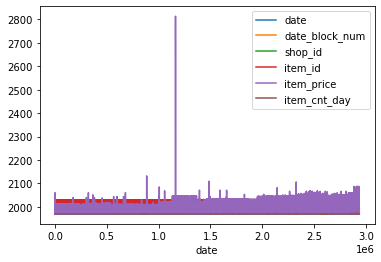

In [17]:
train.plot(xlabel = 'date')         #빈칸으로 두면 index가 자동으로 x축으로 지정됨
plt.show()

<AxesSubplot:>

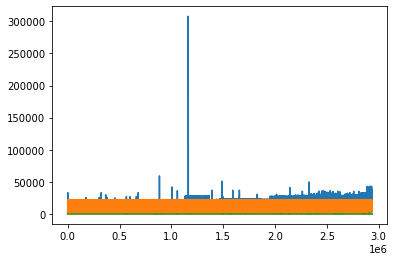

In [18]:
train['item_price'].plot()
train['item_id'].plot()
train['item_cnt_day'].plot()

<AxesSubplot:>

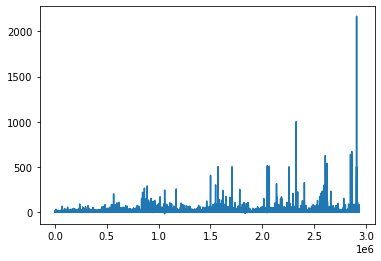

In [19]:
train['item_cnt_day'].plot()

<AxesSubplot:>

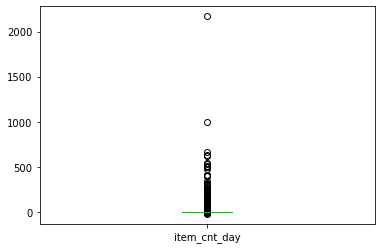

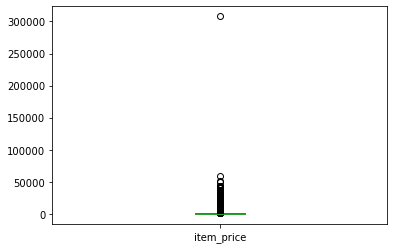

In [20]:
train.plot(kind = 'box', y = 'item_cnt_day')
train.plot(kind = 'box', y = 'item_price')

In [21]:
# Drop training items with extreme or negative prices or sales counts
train = train[(train["item_price"] > 0) & (train["item_price"] < 50000)]
train = train[(train["item_cnt_day"] > 0) & (train["item_cnt_day"] < 1000)]

<AxesSubplot:>

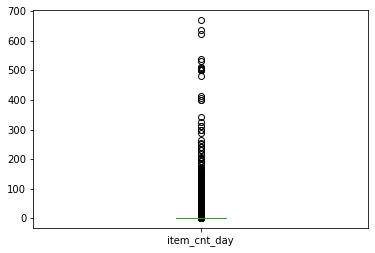

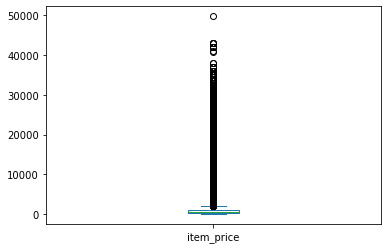

In [22]:
train.plot(kind = 'box', y = 'item_cnt_day')
train.plot(kind = 'box', y = 'item_price')

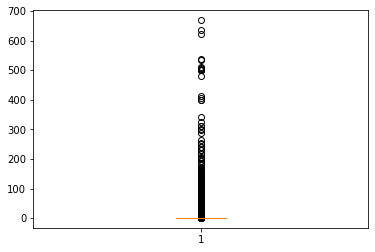

In [23]:
plt.boxplot(train[train.columns[-1]])
plt.show()

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928487 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 156.4 MB


In [25]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
from plotly.subplots import make_subplots
import plotly.graph_objects as go


In [26]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-01-10,0,25,2564,349.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


In [27]:
import copy
train_new = copy.deepcopy(train)

In [28]:
train_new

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-01-10,0,25,2564,349.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


In [29]:
train_new['total_rev'] = train_new.item_cnt_day*train_new.item_price

In [30]:
train_new

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,total_rev
0,2013-01-02,0,59,22154,999.00,1.0,999.00
1,2013-01-03,0,25,2552,899.00,1.0,899.00
3,2013-01-06,0,25,2554,1709.05,1.0,1709.05
4,2013-01-15,0,25,2555,1099.00,1.0,1099.00
5,2013-01-10,0,25,2564,349.00,1.0,349.00
...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,299.00
2935845,2015-10-09,33,25,7460,299.00,1.0,299.00
2935846,2015-10-14,33,25,7459,349.00,1.0,349.00
2935847,2015-10-22,33,25,7440,299.00,1.0,299.00


In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928487 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 156.4 MB


In [32]:
train_p = pd.pivot_table(train_new,
                        index = 'date_block_num',
                        values = 'total_rev',
                        aggfunc = 'sum')
train_p

,total_rev
date_block_num,
0,9.239909e+07
1,9.096449e+07
2,1.052654e+08
3,6.945713e+07
4,6.525317e+07
5,7.976249e+07
6,6.953452e+07
7,7.458699e+07
8,1.192588e+08


<AxesSubplot:xlabel='date_block_num'>

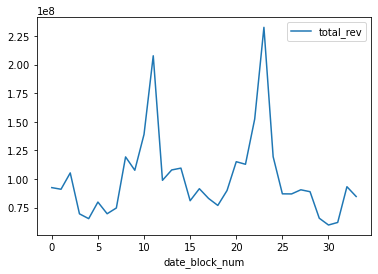

In [33]:
train_p.plot()

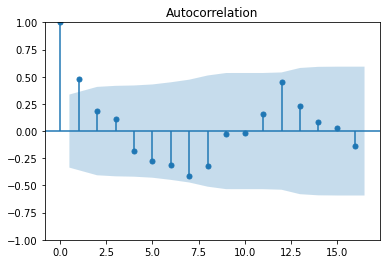

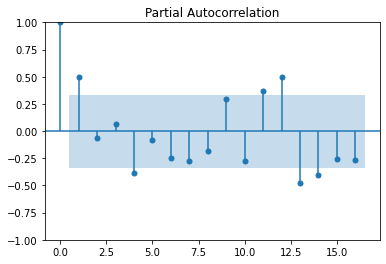

In [34]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(train_p)
plot_pacf(train_p)
plt.show()

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 16 must be < 16.

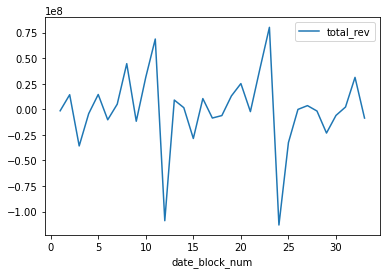

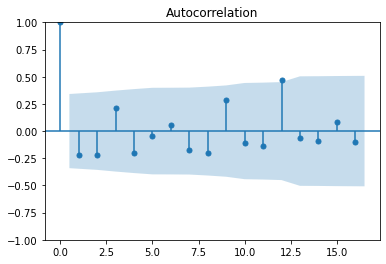

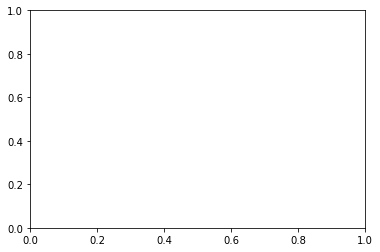

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

diff_1=train_p.diff(periods=1).iloc[1:]
diff_1.plot()
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

In [36]:
diff_1

,total_rev
date_block_num,
1,-1.434602e+06
2,1.430088e+07
3,-3.580824e+07
4,-4.203959e+06
5,1.450933e+07
6,-1.022797e+07
7,5.052466e+06
8,4.467181e+07
9,-1.166296e+07


In [38]:
import statsmodels.api as sm

model = sm.tsa.arima.ARIMA(train_p, order=(0,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              total_rev   No. Observations:                   34
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -621.558
Date:                Wed, 06 Jul 2022   AIC                           1247.116
Time:                        16:40:52   BIC                           1250.109
Sample:                             0   HQIC                          1248.123
                                 - 34                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2991      0.109     -2.744      0.006      -0.513      -0.085
sigma2      1.486e+15   1.07e-17   1.39e+32      0.000    1.49e+15    1.49e+15
Ljung-Box (L1) (Q):                   0.01   Jarque-